# Imports and configs

In [1]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
import matplotlib.pyplot as plt
from scipy.special import logit
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import optuna
import glob
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e10/train.csv'
    test_path = '/kaggle/input/playground-series-s4e10/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e10/sample_submission.csv'
    
    oof_path = '/kaggle/input/s04e10-loan-approval-prediction-autogluon'
    
    target = 'loan_status'
    n_folds = 5
    seed = 1859

# Loading OOF files

In [3]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]

In [4]:
def get_data(oof_path, test_oof_path):
    oof_pred_probs = pickle.load(open(oof_path, 'rb'))
    test_pred_probs = pickle.load(open(test_oof_path, 'rb'))
    
    scores = []
    skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]   
        score = roc_auc_score(y_val, y_pred_probs)
        scores.append(score)
        
    return oof_pred_probs, test_pred_probs, scores

In [5]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [6]:
oof_paths = glob.glob(f'{CFG.oof_path}/oof_pred_probs/**')
test_oof_paths = glob.glob(f'{CFG.oof_path}/test_pred_probs/**')
for oof_path, test_oof_path in zip(oof_paths, test_oof_paths):
    model_name = oof_path.split('/')[-1][:-28]
    if "L1" in model_name and "PSEUDO" in model_name:
        oof_pred_probs[model_name], test_pred_probs[model_name], scores[model_name] = get_data(oof_path, test_oof_path)

# L2 Logistic Regression

In [7]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            iters = model.n_iter_
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict(X_test) if isinstance(self.model, Ridge) else model.predict_proba(X_test)[:, 1]
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - AUC: {score:.6f}' + ('' if isinstance(self.model, Ridge) else f' ({iters[0]} iterations)'))
            
        overall_score = roc_auc_score(y, oof_pred_probs)
        
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')   
        
        return oof_pred_probs, test_pred_probs, scores
    
    def fit(self, X, y):
        scores = []                
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect() 
        
        return np.mean(scores)

In [8]:
def save_submission(name, test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)
    return sub.head()

In [9]:
l2_oof_pred_probs = {}
l2_test_pred_probs = {}

In [10]:
X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-1e-15))
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1-1e-15))

In [11]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'max_iter': 1000,
        'C': trial.suggest_float('C', 0, 1),
        'tol': trial.suggest_float('tol', 1e-6, 1e-2)
    }
    model = LogisticRegression(**params)
    trainer = Trainer(model)
    return trainer.fit(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500, n_jobs=-1)
lr_params = study.best_params
print(lr_params)

[I 2024-10-08 10:09:53,370] A new study created in memory with name: no-name-039c8777-7756-4044-a504-0e0a7cf2f787
[I 2024-10-08 10:10:39,769] Trial 1 finished with value: 0.9637739968913948 and parameters: {'C': 0.7398717689618134, 'tol': 0.005352124017230862}. Best is trial 1 with value: 0.9637739968913948.
[I 2024-10-08 10:10:41,188] Trial 0 finished with value: 0.9637723419846858 and parameters: {'C': 0.7557886705549325, 'tol': 0.004779857285763085}. Best is trial 1 with value: 0.9637739968913948.
[I 2024-10-08 10:10:41,576] Trial 2 finished with value: 0.9637689369248379 and parameters: {'C': 0.9547905731118113, 'tol': 0.009761392369140908}. Best is trial 1 with value: 0.9637739968913948.
[I 2024-10-08 10:10:43,316] Trial 3 finished with value: 0.9637717586003062 and parameters: {'C': 0.8800785985401561, 'tol': 0.0033710041562196925}. Best is trial 1 with value: 0.9637739968913948.
[I 2024-10-08 10:11:23,209] Trial 4 finished with value: 0.9637965226719242 and parameters: {'C': 0.2

{'C': 0.015606647270319863, 'tol': 0.0040937420992918794}


In [12]:
lr_model = LogisticRegression(random_state=CFG.seed, max_iter=1000, **lr_params)
lr_trainer = Trainer(lr_model)
l2_oof_pred_probs['LR_Ensemble_L2'], l2_test_pred_probs['LR_Ensemble_L2'], scores['LR_Ensemble_L2'] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - AUC: 0.967132 (159 iterations)
--- Fold 2 - AUC: 0.965098 (149 iterations)
--- Fold 3 - AUC: 0.963678 (138 iterations)
--- Fold 4 - AUC: 0.960715 (125 iterations)
--- Fold 5 - AUC: 0.962968 (128 iterations)

------ Overall: 0.963926 | Average: 0.963918 ± 0.002142


In [13]:
save_submission('lr-ensemble-l2', l2_test_pred_probs['LR_Ensemble_L2'], np.mean(scores['LR_Ensemble_L2']))

,id,loan_status
0,58645,0.999322
1,58646,0.055711
2,58647,0.497077
3,58648,0.011729
4,58649,0.079941


# L2 Ridge

In [14]:
X = pd.DataFrame(oof_pred_probs)
X_test = pd.DataFrame(test_pred_probs)

In [15]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 50),
        'tol': trial.suggest_float('tol', 1e-6, 1e-2)
    }
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.fit(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500, n_jobs=-1)
ridge_params = study.best_params
print(ridge_params)

[I 2024-10-08 11:19:34,318] A new study created in memory with name: no-name-21d1b0a5-19e1-403c-92b0-b360236da916
[I 2024-10-08 11:19:37,761] Trial 0 finished with value: 0.9633297913567438 and parameters: {'alpha': 36.09217419515375, 'tol': 0.007522522058234604}. Best is trial 0 with value: 0.9633297913567438.
[I 2024-10-08 11:19:38,219] Trial 3 finished with value: 0.9633296246754925 and parameters: {'alpha': 33.78994862323045, 'tol': 0.007296443818178974}. Best is trial 0 with value: 0.9633297913567438.
[I 2024-10-08 11:19:38,444] Trial 1 finished with value: 0.9633091466931928 and parameters: {'alpha': 47.27417011318417, 'tol': 0.0022545979593820878}. Best is trial 0 with value: 0.9633297913567438.
[I 2024-10-08 11:19:38,649] Trial 2 finished with value: 0.9628419748632767 and parameters: {'alpha': 3.1753910339748725, 'tol': 0.0013294783237758699}. Best is trial 0 with value: 0.9633297913567438.
[I 2024-10-08 11:19:41,871] Trial 4 finished with value: 0.9631968868704582 and paramet

{'alpha': 29.518317632906484, 'tol': 0.009865511015177233}


In [16]:
ridge_model = Ridge(random_state=CFG.seed, positive=True, **ridge_params)
ridge_trainer = Trainer(ridge_model)
l2_oof_pred_probs['Ridge_Ensemble_L2'], l2_test_pred_probs['Ridge_Ensemble_L2'], scores['Ridge_Ensemble_L2'] = ridge_trainer.fit_predict(X, y, X_test)

Training Ridge

--- Fold 1 - AUC: 0.965008
--- Fold 2 - AUC: 0.963605
--- Fold 3 - AUC: 0.961761
--- Fold 4 - AUC: 0.957833
--- Fold 5 - AUC: 0.962045

------ Overall: 0.962065 | Average: 0.962050 ± 0.002410


In [17]:
save_submission('ridge-ensemble-l2', l2_test_pred_probs['Ridge_Ensemble_L2'], np.mean(scores['Ridge_Ensemble_L2']))

,id,loan_status
0,58645,0.985596
1,58646,0.022019
2,58647,0.571486
3,58648,0.006677
4,58649,0.063714


# L3 weighted ensemble

In [18]:
def objective(trial):
    weights = [trial.suggest_float(l2_model_name, 0, 1) for l2_model_name in l2_oof_pred_probs.keys()]
    weights /= np.sum(weights)
    weights = [round(w, 3) for w in weights]
    
    preds = np.zeros(X.shape[0])
    for model, weight in zip(l2_oof_pred_probs.keys(), weights):
        preds += l2_oof_pred_probs[model] * weight
    
    return roc_auc_score(y.values, preds)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500, n_jobs=-1)

[I 2024-10-08 11:26:54,759] A new study created in memory with name: no-name-e59c348b-86ab-4704-a7bd-689f9adff7d3
[I 2024-10-08 11:26:54,807] Trial 0 finished with value: 0.963087305853548 and parameters: {'LR_Ensemble_L2': 0.3666652625440914, 'Ridge_Ensemble_L2': 0.8998720405688448}. Best is trial 0 with value: 0.963087305853548.
[I 2024-10-08 11:26:54,815] Trial 2 finished with value: 0.9636611894016917 and parameters: {'LR_Ensemble_L2': 0.7890369859333288, 'Ridge_Ensemble_L2': 0.6776133194529944}. Best is trial 2 with value: 0.9636611894016917.
[I 2024-10-08 11:26:54,824] Trial 1 finished with value: 0.963982800876029 and parameters: {'LR_Ensemble_L2': 0.7450009563572161, 'Ridge_Ensemble_L2': 0.08803762398714243}. Best is trial 1 with value: 0.963982800876029.
[I 2024-10-08 11:26:54,827] Trial 3 finished with value: 0.9637662962175856 and parameters: {'LR_Ensemble_L2': 0.1949987315882784, 'Ridge_Ensemble_L2': 0.12847867291123727}. Best is trial 1 with value: 0.963982800876029.
[I 20

In [19]:
scores['Weighted_Ensemble_L3'] = [study.best_value] * CFG.n_folds

In [20]:
best_weights = study.best_params
best_weights = [best_weights[l2_model] for l2_model in l2_oof_pred_probs.keys()]
best_weights /= np.sum(best_weights)
best_weights = [round(w, 3) for w in best_weights]

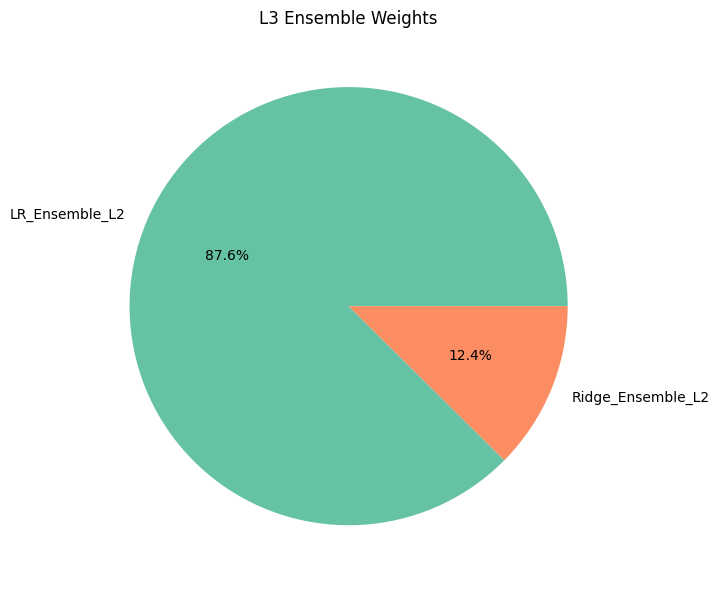

In [21]:
plt.figure(figsize=(10, 6))
plt.pie(study.best_params.values(), labels=study.best_params.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', 2))
plt.title("L3 Ensemble Weights")
plt.tight_layout()
plt.show()

In [22]:
weighted_test_preds = np.zeros((X_test.shape[0]))
for model, weight in zip(l2_test_pred_probs.keys(), best_weights):
    weighted_test_preds += l2_test_pred_probs[model] * weight

In [23]:
save_submission('weighted-ensemble-l3', weighted_test_preds, np.mean(scores['Weighted_Ensemble_L3']))

,id,loan_status
0,58645,0.997620
1,58646,0.051533
2,58647,0.506304
3,58648,0.011103
4,58649,0.077929


# Results

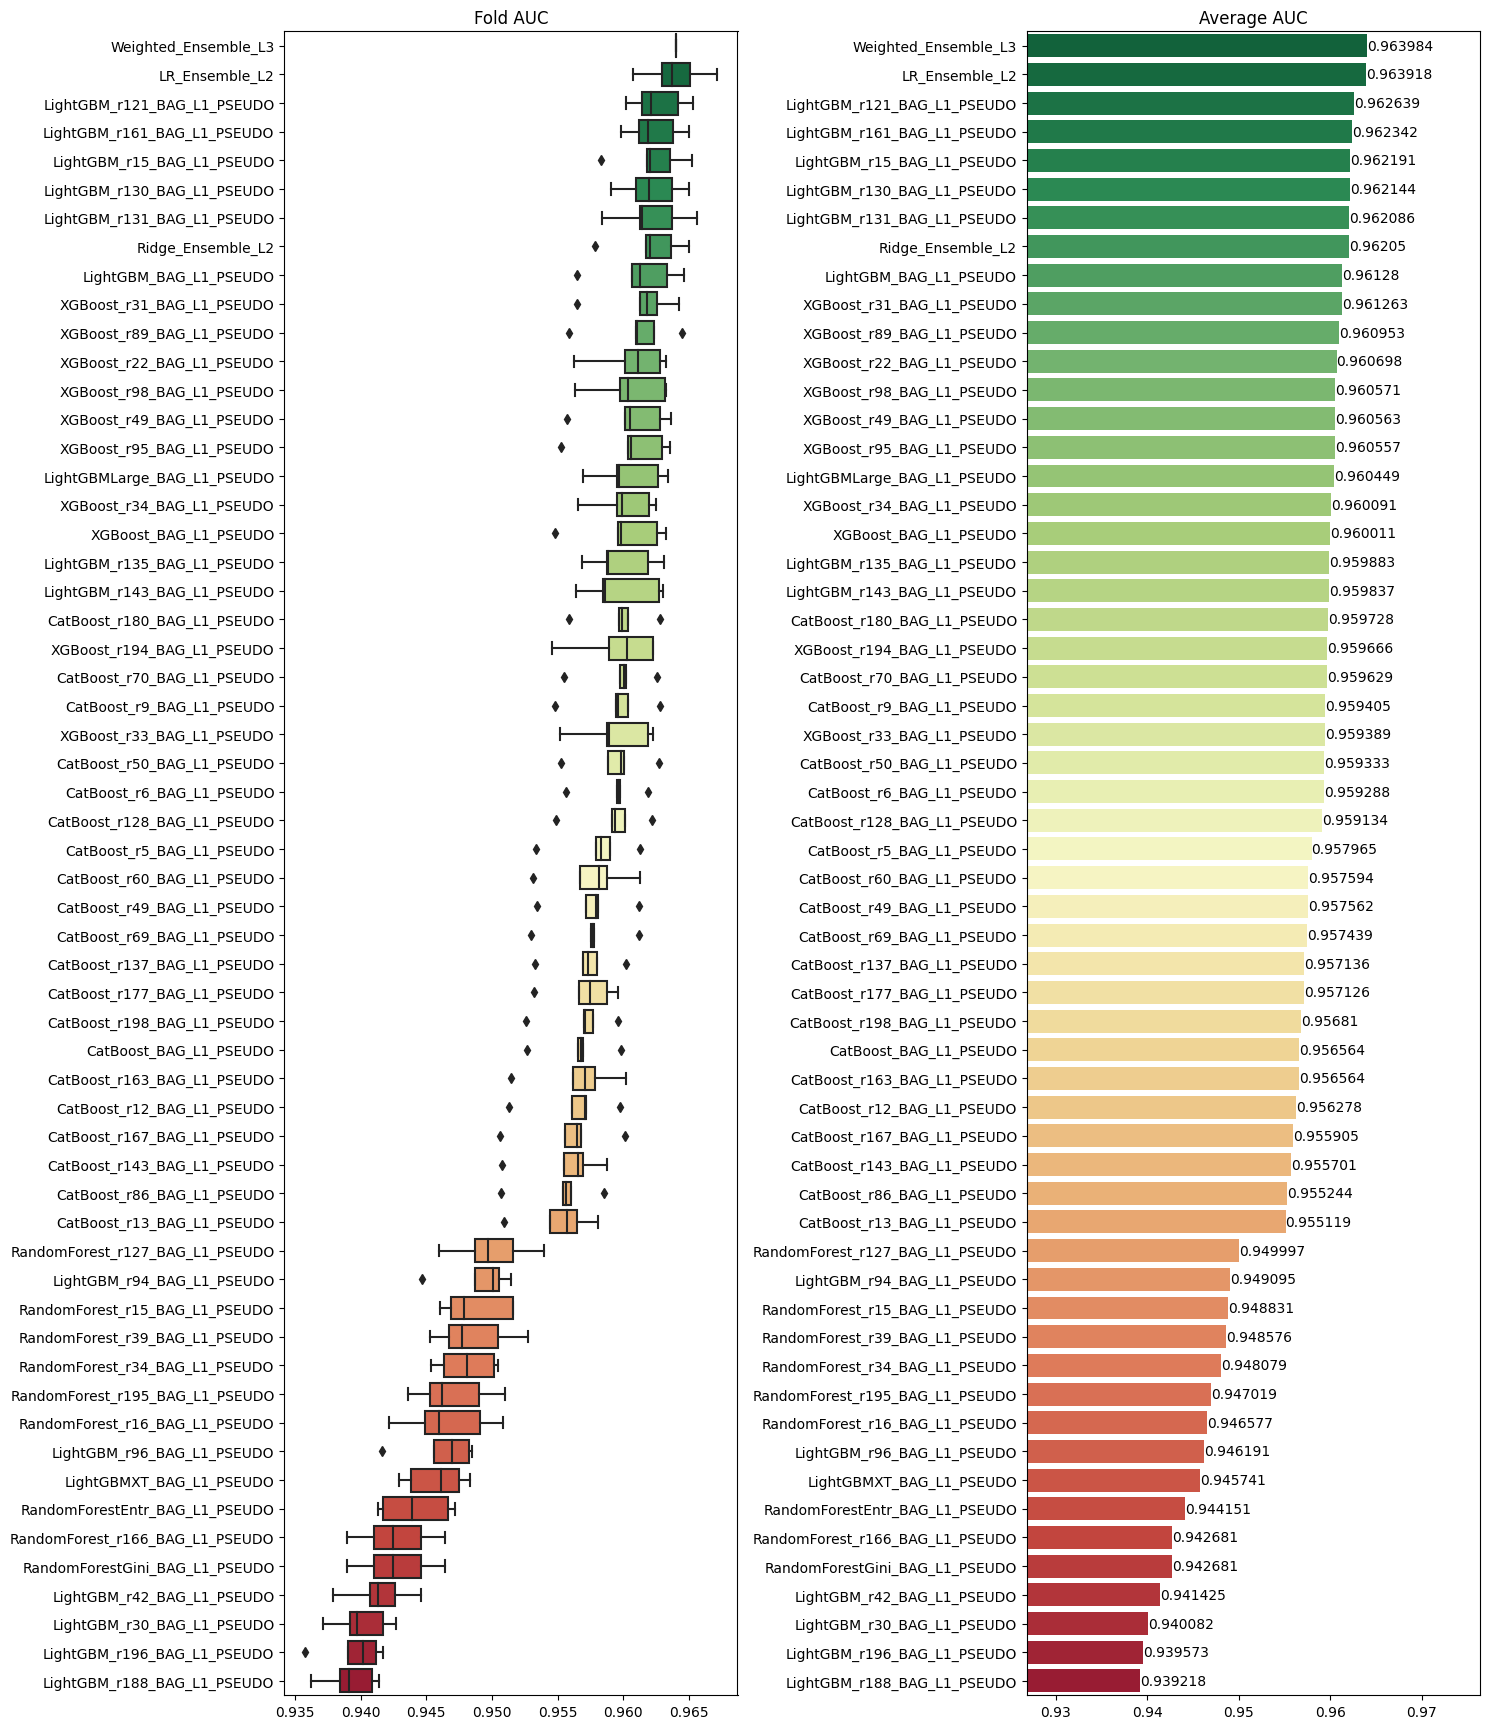

In [24]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()